In [58]:
!ls

dataset.csv     movielens       predictions
models          movielens.ipynb splits


In [59]:
!ls movielens/ml-latest-small/

README.txt    movielens.csv ratings.csv
links.csv     movies.csv    tags.csv


In [60]:
import pandas as pd
import numpy as np

In [61]:
# plots snippet
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%config InlineBackend.figure_format = 'png'
rcParams['figure.figsize'] = (16, 6)

In [62]:
ratings = pd.read_csv('movielens/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [63]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [64]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [65]:
ratings["movie_id"] = ratings["movieId"].astype("category").cat.codes.copy() + 1
ratings_for_mrec = ratings[["userId", "movie_id", "rating"]]

In [66]:
ratings_for_mrec.describe()

,userId,movie_id,rating
count,100004.000000,100004.000000,100004.000000
mean,347.011310,2692.887445,3.543608
std,195.163838,2375.936209,1.058064
min,1.000000,1.000000,0.500000
25%,182.000000,833.000000,3.000000
50%,367.000000,1917.500000,4.000000
75%,520.000000,4122.000000,4.000000
max,671.000000,9066.000000,5.000000


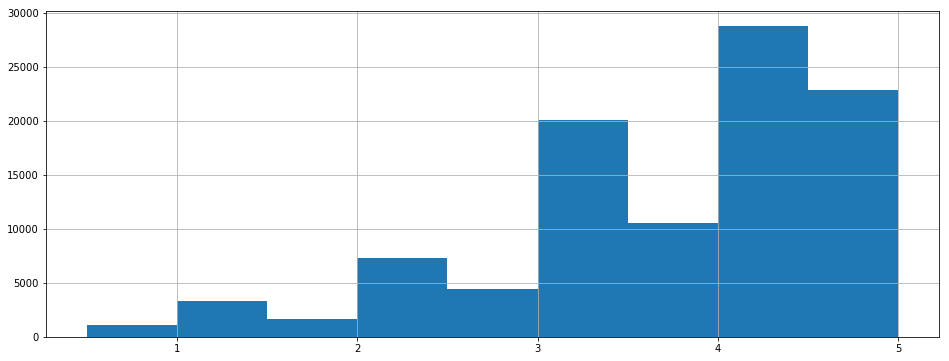

In [67]:
ratings_for_mrec['rating'].hist(bins=9)

# Подгатавливаем датасет для обучения

In [68]:
ratings_for_mrec.to_csv('dataset.csv', header=False, index=False)

In [69]:
from mrec.evaluation.preprocessing import TSVParser, SplitCreator
from mrec.examples.filename_conventions import get_sortedfile, get_splitfile
from mrec.examples.prepare import Processor
import subprocess
import os

In [70]:
dataset = os.path.abspath('dataset.csv')
splits_outdir = os.path.abspath('splits')

print('sorting input data...')
infile = get_sortedfile(dataset, splits_outdir)
subprocess.check_call(['mkdir', '-p', splits_outdir])
subprocess.check_call(['sort', '-k1', '-n', dataset], stdout=open(infile, 'w'))

parser = TSVParser(thresh=4, delimiter=',', binarize=True)
splitter = SplitCreator(test_size=0.5)
processor = Processor(splitter, parser, min_items_per_user=10)

for i in range(5):
    trainfile = get_splitfile(dataset, splits_outdir, 'train', i)
    testfile = get_splitfile(dataset, splits_outdir, 'test', i)

    print('creating split {0}: {1} {2}'.format(i, trainfile, testfile))
    infile_, trainfile_, testfile_ = open(infile), open(trainfile, 'w'), open(testfile, 'w')
    processor.create_split(infile_, trainfile_, testfile_)
    infile_.close()
    trainfile_.close()
    testfile_.close()

    too_few_items = processor.get_too_few_items()
    if too_few_items:
        print('skipped {0} users with less than {1} ratings'.format(too_few_items, 10))
        
print('cleaning up...')
subprocess.check_call(['rm', infile])
print('done')

sorting input data...
creating split 0: /Users/a.burtsev/Develop/netology-practice/4.2-movielens/splits/dataset.csv.train.0 /Users/a.burtsev/Develop/netology-practice/4.2-movielens/splits/dataset.csv.test.0
creating split 1: /Users/a.burtsev/Develop/netology-practice/4.2-movielens/splits/dataset.csv.train.1 /Users/a.burtsev/Develop/netology-practice/4.2-movielens/splits/dataset.csv.test.1
creating split 2: /Users/a.burtsev/Develop/netology-practice/4.2-movielens/splits/dataset.csv.train.2 /Users/a.burtsev/Develop/netology-practice/4.2-movielens/splits/dataset.csv.test.2
creating split 3: /Users/a.burtsev/Develop/netology-practice/4.2-movielens/splits/dataset.csv.train.3 /Users/a.burtsev/Develop/netology-practice/4.2-movielens/splits/dataset.csv.test.3
creating split 4: /Users/a.burtsev/Develop/netology-practice/4.2-movielens/splits/dataset.csv.train.4 /Users/a.burtsev/Develop/netology-practice/4.2-movielens/splits/dataset.csv.test.4
cleaning up...
done


# Обучаемся

In [71]:
import glob
trainfiles = glob.glob('splits/dataset.csv.train.*')

In [72]:
from mrec.examples.filename_conventions import *
from mrec.parallel.item_similarity import ItemSimilarityRunner
from ipyparallel import Client
from multiprocessing.pool import Pool
from multiprocessing import cpu_count

In [73]:
class MrecPool(Pool):
    def map_async(self, process, tasks, retries=2):
        return super(MrecPool, self).map_async(process, tasks)
    
cpus = cpu_count()
pool = MrecPool(cpus)

## Popularity

In [74]:
from mrec.popularity import ItemPopularityRecommender
from mrec import load_fast_sparse_matrix, save_recommender

In [75]:
train_outdir = os.path.abspath('models/popularity')
subprocess.check_call(['mkdir', '-p', train_outdir])

for trainfile in trainfiles:
    print('processing {0}...'.format(trainfile))
    dataset = load_fast_sparse_matrix('tsv', trainfile)
    model = ItemPopularityRecommender()
    model.fit(dataset)
    modelfile = get_modelfile(trainfile, train_outdir)
    save_recommender(model, modelfile)

print('done')

processing splits/dataset.csv.train.0...
processing splits/dataset.csv.train.1...
processing splits/dataset.csv.train.4...
processing splits/dataset.csv.train.3...
processing splits/dataset.csv.train.2...
done


## KNN

In [76]:
from mrec.item_similarity.knn import CosineKNNRecommender, DotProductKNNRecommender

In [77]:
model = CosineKNNRecommender(k=100)
train_outdir = os.path.abspath('models/knn')

subprocess.check_call(['mkdir', '-p', train_outdir])

for trainfile in trainfiles:
    print('processing {0}...'.format(trainfile))
    modelfile = get_modelfile(trainfile, train_outdir)
    runner = ItemSimilarityRunner()
    simsdir = get_simsdir(trainfile, train_outdir)
    simsfile = get_simsfile(trainfile, train_outdir)
    runner.run(pool, model, 'tsv', trainfile, cpus, simsdir, True, 100, simsfile, modelfile)

print('done')

processing splits/dataset.csv.train.0...
processing splits/dataset.csv.train.1...
processing splits/dataset.csv.train.4...
processing splits/dataset.csv.train.3...
processing splits/dataset.csv.train.2...
done


## SLIM

In [78]:
from mrec.item_similarity.slim import SLIM

In [79]:
model=SLIM(model='sgd')
train_outdir = os.path.abspath('models/slim')

subprocess.check_call(['mkdir', '-p', train_outdir])

for trainfile in trainfiles:
    print('processing {0}...'.format(trainfile))
    modelfile = get_modelfile(trainfile, train_outdir)
    runner = ItemSimilarityRunner()
    simsdir = get_simsdir(trainfile, train_outdir)
    simsfile = get_simsfile(trainfile, train_outdir)
    runner.run(pool, model, 'tsv', trainfile, cpus, simsdir, True, 100, simsfile, modelfile)

print('done')

processing splits/dataset.csv.train.0...


/Users/a.burtsev/miniconda3/envs/netology/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


processing splits/dataset.csv.train.1...
processing splits/dataset.csv.train.4...
processing splits/dataset.csv.train.3...
processing splits/dataset.csv.train.2...
done


# Получаем рекомендации

In [80]:
from mrec.evaluation.metrics import compute_main_metrics, compute_hit_rate
from mrec.evaluation import Evaluator
from mrec.evaluation.metrics import print_report
from mrec.examples.predict import process
from collections import defaultdict
from argparse import Namespace
import psutil

ONE_MB = 2 ** 20

In [81]:
def make_predictions(modeldir, predict_outdir):
    evaluator = Evaluator(compute_main_metrics, max_items=20)

    descriptions = set()
    all_metrics = defaultdict(list)

    mb_per_task = psutil.virtual_memory().available / ONE_MB / (cpus + 1)

    opts = Namespace(input_format='tsv',
                     test_input_format='tsv',
                     item_feature_format='tsv',
                     outdir=predict_outdir,
                     overwrite=False,
                     mb_per_task=mb_per_task)

    for trainfile in trainfiles:
        print('processing {0}...'.format(trainfile))
        modelfile = get_modelfile(trainfile, modeldir)
        testfile = get_testfile(trainfile)
        description, metrics = process(pool, opts, modelfile, trainfile, testfile, None, predict_outdir, evaluator)
        descriptions.add(description)
        if metrics is not None:
            for m in metrics:
                all_metrics[m].append(metrics[m])

    description = ' AND '.join(descriptions)
    if len(descriptions) > 1:
        print('You are aggregating metrics from different models! {}'.format(description))

    print_report([description], [all_metrics])

## Popularity

In [82]:
make_predictions(modeldir=os.path.abspath('models/popularity'), predict_outdir=os.path.abspath('predictions/popularity'))

processing splits/dataset.csv.train.0...
processing splits/dataset.csv.train.1...
processing splits/dataset.csv.train.4...
processing splits/dataset.csv.train.3...
processing splits/dataset.csv.train.2...
ItemPop
mrr            0.4406 +/- 0.0033
prec@5         0.2507 +/- 0.0014
prec@10        0.2122 +/- 0.0015
prec@15        0.1910 +/- 0.0009
prec@20        0.1756 +/- 0.0004


## KNN

In [83]:
make_predictions(modeldir=os.path.abspath('models/knn'), predict_outdir=os.path.abspath('predictions/knn'))

processing splits/dataset.csv.train.0...
processing splits/dataset.csv.train.1...
processing splits/dataset.csv.train.4...
processing splits/dataset.csv.train.3...
processing splits/dataset.csv.train.2...
CosineKNNRecommender(k=100)
mrr            0.4366 +/- 0.0055
prec@5         0.2547 +/- 0.0023
prec@10        0.2093 +/- 0.0016
prec@15        0.1800 +/- 0.0006
prec@20        0.1612 +/- 0.0008


## SLIM

In [84]:
make_predictions(modeldir=os.path.abspath('models/slim'), predict_outdir=os.path.abspath('predictions/slim'))

processing splits/dataset.csv.train.0...
processing splits/dataset.csv.train.1...
processing splits/dataset.csv.train.4...
processing splits/dataset.csv.train.3...
processing splits/dataset.csv.train.2...
SLIM(SGDRegressor(alpha=0.0011, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=False, l1_ratio=0.9090909090909091,
       learning_rate='invscaling', loss='squared_loss', max_iter=5,
       n_iter=None, penalty='elasticnet', power_t=0.25, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))
mrr            0.5743 +/- 0.0036
prec@5         0.3609 +/- 0.0021
prec@10        0.3088 +/- 0.0022
prec@15        0.2745 +/- 0.0012
prec@20        0.2499 +/- 0.0009
